# Starbucks offers

In this project we will take a look at Starbucks' offers and what type of offers each type of customer prefers

# Q1 what is offer in general customers Prefer?
# Q2 Does preference for offers differ according to gender? Which gender prefers offers more?
# Q3 Does preference for offers differ according to income? 

In [ ]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV



# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_csv('transcript.csv')

In [ ]:
def plot_bar(data):
    """
    Plot a bar chart for offer completion percentage.

    Parameters:
        data (DataFrame): The data to be plotted, expected to be in DataFrame format.

    Returns:
        None
    """
    data.plot(kind='bar')
    plt.title('Offer Completion Percentage')
    plt.xlabel('Offer Type')
    plt.ylabel('Completion Percentage')
    plt.show()

In [ ]:
def plot_stack (data,category):

    """
    Plot stacked bar chart for data categorized by a given category.

    Parameters:
        data (DataFrame): The data to be plotted, expected to be in DataFrame format.
        category (str): The category by which the data will be categorized.

    Returns:
        None
    """
    # Plot the data
    data.unstack().plot(kind='bar')
    plt.title(category+' Offer Completion Percentage')
    plt.xlabel(category)
    plt.ylabel('Completion Percentage')
    plt.legend(title='Offer Type')
    plt.show()

# Data Understanding

In [ ]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [ ]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [ ]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [ ]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283122 entries, 0 to 283121
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  283122 non-null  object
 1   event   283122 non-null  object
 2   value   283122 non-null  object
 3   time    283122 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 8.6+ MB


# Data Processing and Cleaning

In [ ]:
# new column 'ids', where each id string is replaced by an alphabetical ID
unique_offer = portfolio['id'].unique()
offer_to_id = {email: chr(ord('A') + idx) for idx, email in enumerate(unique_offer)}
portfolio['ids'] = portfolio['id'].map(offer_to_id)

# new column 'duration_h' duration in hours
portfolio['duration_h'] = portfolio['duration'] *24

# Drop columns
portfolio = portfolio.drop(columns=['id'])

# Reassign DataFrame with desired column order
portfolio = portfolio[['channels','difficulty','duration','duration_h','ids', 'offer_type','reward']]

In [ ]:
# new column 'ids', where each id string is replaced by an integer ID
unique_id = profile['id'].unique()
id_to_ids = {id: idx for idx, id in enumerate(unique_id)}
profile['ids'] = profile['id'].map(id_to_ids)

# Drop columns
profile = profile.drop(columns=['id'])

# Reassign DataFrame with desired column order
profile = profile[['age','became_member_on','gender','ids','income']]

In [ ]:
profile.tail()

,age,became_member_on,gender,ids,income
16995,45,20180604,F,16995,54000.0
16996,61,20180713,M,16996,72000.0
16997,49,20170126,M,16997,73000.0
16998,83,20160307,F,16998,50000.0
16999,62,20170722,F,16999,82000.0


In [ ]:
transcript['value'] = transcript['value'].apply(eval)
# Extract dic value into new column
transcript['value_in'] = transcript['value'].apply(lambda x: x[list(x.keys())[0]])
# new column 'ids', where each id string is replaced by an alphabetical ID

# map offer string id  into alphabetical id
transcript.loc[transcript['event'] != 'transaction', 'value_in'] = transcript.loc[transcript['event'] != 'transaction', 'value_in'].map(offer_to_id)

# new column 'person_id', where each person string is replaced by an integer ID
transcript['person_id'] = transcript['person'].map(id_to_ids)

# Drop columns
transcript = transcript.drop(columns=['person','value'])

In [ ]:
transcript.head()#['event'].unique()

,event,time,value_in,person_id
0,offer received,0,D,3
1,offer received,0,E,4
2,offer received,0,J,5
3,offer received,0,G,6
4,offer received,0,B,7


### we want to create new data  with new column 'complet'  front each offer received put 1 if completed and 0 if not completed 

In [ ]:
# new df TRC (transcript received complet)
TRC = transcript[transcript['event'].isin(['offer received','offer completed'])]
TRC['complet'] = np.nan

C:\Users\o\AppData\Local\Temp\ipykernel_15756\1283734204.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TRC['complet'] = np.nan


In [ ]:
# merge TRC with portfolio to get 'duration' column
TRC=pd.merge(TRC, portfolio[['duration_h','offer_type','ids']], left_on='value_in', right_on='ids', how='left')
TRC.drop(columns=['ids'], inplace=True)

In [ ]:
# new column 'time_end'
cond = (TRC['event'] == 'offer received') # condition
TRC.loc[cond, 'time_end'] = TRC.loc[cond, 'time']+TRC.loc[cond, 'duration_h']

### loop throw each offer received event for each person and put 1 if offer completed and 0 if not completed

### <font color='red'> Warning </p>: The code may take more than 40 minutes to save time loading data from the next cell after it

In [ ]:
person_list=TRC['person_id'].unique().tolist()
for index, person in enumerate(person_list):
    if index % 1700 == 0:
        print(f"{index / len(person_list) * 100:.2f}%")
    df_hhh =TRC[TRC['person_id']==person]
    df_received = df_hhh[df_hhh['event']=='offer received']
    df_completed = df_hhh[df_hhh['event']=='offer completed']
    for i in range(df_received.shape[0]):
        offer_id = df_received.iloc[i]['value_in']
        offer_start = df_received.iloc[i]['time']
        offer_end = df_received.iloc[i]['time_end']
        cond = ((df_completed['value_in']==offer_id)&(df_completed['time']<=offer_end) &(df_completed['time']>=offer_start))
        check = df_completed[cond]

        event = 'offer received'
        cond = ((TRC['person_id']==person) & (TRC['event']==event)&(TRC['value_in']==offer_id) & (TRC['time']==offer_start))
        if len(check)>0:
            TRC.loc[cond, 'complet'] = 1

        else:
            TRC.loc[cond, 'complet'] = 0

        
    

In [ ]:
#transcript_received_complet=TRC
#transcript_received_complet.to_csv('TRC.csv', index=False)

In [ ]:
transcript_received_complet = pd.read_csv('TRC.csv')

In [ ]:
transcript_received_complet

,event,time,value_in,person_id,complet,duration_h,offer_type,time_end
0,offer received,0,D,3,1.0,168,bogo,168.0
1,offer received,0,E,4,0.0,240,discount,240.0
2,offer received,0,J,5,0.0,168,discount,168.0
3,offer received,0,G,6,0.0,240,discount,240.0
4,offer received,0,B,7,0.0,120,bogo,120.0
...,...,...,...,...,...,...,...,...
109851,offer completed,714,F,16338,NaN,168,discount,NaN
109852,offer completed,714,F,16664,NaN,168,discount,NaN
109853,offer completed,714,G,16764,NaN,240,discount,NaN
109854,offer completed,714,G,16767,NaN,240,discount,NaN


In [ ]:
TRC = transcript_received_complet

In [ ]:
# new data fream TR 
TR = TRC[TRC['event']=='offer received']

#### Due to the data range time, some offers were received and the range time expired before the validity period expiry, let's fix that

In [ ]:
max_time = transcript['time'].max()
TR = TR[~((TR['time']>(max_time - TR['duration_h']))& (TR['complet']==0 ))]

In [ ]:
TR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71560 entries, 0 to 102054
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   event       71560 non-null  object 
 1   time        71560 non-null  int64  
 2   value_in    71560 non-null  object 
 3   person_id   71560 non-null  int64  
 4   complet     71560 non-null  float64
 5   duration_h  71560 non-null  int64  
 6   offer_type  71560 non-null  object 
 7   time_end    71560 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 4.9+ MB


In [ ]:
new_data =pd.merge(TR, profile, left_on='person_id', right_on='ids', how='inner')
new_data.drop(columns=['ids','became_member_on','event','time','duration_h','time_end','person_id'], inplace=True)
new_data = new_data.dropna()

In [ ]:
# Rename the 'value_in' column to 'offer'
new_data = new_data.rename(columns={'value_in': 'offer'})

#### for purpose of analysis we need to categorize income

In [ ]:
low_income_threshold = new_data['income'].quantile(0.2)
high_income_threshold = new_data['income'].quantile(0.8)

# Categorize income
def categorize_income(income):
    if income < low_income_threshold:
        return 'Low'
    elif income < high_income_threshold:
        return 'Medium'
    else:
        return 'High'

# Apply categorization function to the 'Income' column
new_data['income_category'] = new_data['income'].apply(categorize_income)


#### informational offer does not really offer because that we drop it and drop other because it is low

In [ ]:
# drop informational offer
new_data = new_data[~(new_data['offer_type']=='informational')]
new_data = new_data[~(new_data['gender']=='O')]

In [ ]:
new_data.head()

,offer,complet,offer_type,age,gender,income,income_category
0,D,1.0,bogo,75,F,100000.0,High
2,A,1.0,bogo,75,F,100000.0,High
3,I,1.0,bogo,75,F,100000.0,High
7,J,0.0,discount,68,M,70000.0,Medium
9,D,1.0,bogo,68,M,70000.0,Medium


# EDA

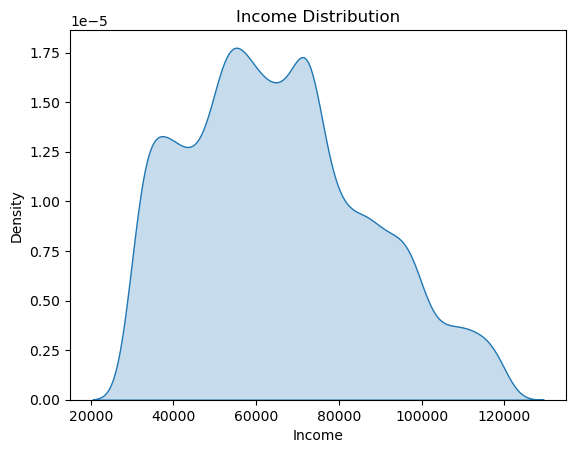

In [ ]:
import seaborn as sns

# Plot KDE plot
sns.kdeplot(profile['income'], shade=True)

# Add title and labels
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Density')

# Show the plot
plt.show()


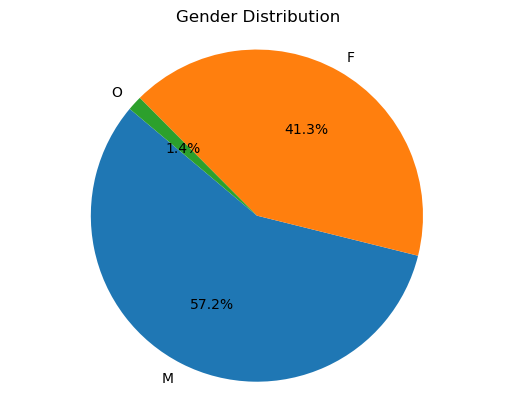

In [ ]:
# Count the occurrences of each gender
gender_counts = profile['gender'].value_counts()

# Plot the pie chart
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)

# Add title
plt.title('Gender Distribution')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Show the plot
plt.show()

# Evaluate

## Q1 what is offer in general customers Prefer?

In [ ]:
new_data

,offer,complet,offer_type,age,gender,income,income_category
0,D,1.0,bogo,75,F,100000.0,High
2,A,1.0,bogo,75,F,100000.0,High
3,I,1.0,bogo,75,F,100000.0,High
7,J,0.0,discount,68,M,70000.0,Medium
9,D,1.0,bogo,68,M,70000.0,Medium
...,...,...,...,...,...,...,...
71554,J,1.0,discount,59,M,44000.0,Low
71556,I,1.0,bogo,51,M,56000.0,Medium
71557,D,1.0,bogo,61,M,73000.0,Medium
71558,F,1.0,discount,52,F,86000.0,High


In [ ]:
offer_percent= new_data.groupby(['offer_type'])['complet'].sum()/new_data.groupby(['offer_type'])['complet'].count()
offer_percent

offer_type
bogo        0.595164
discount    0.715871
Name: complet, dtype: float64

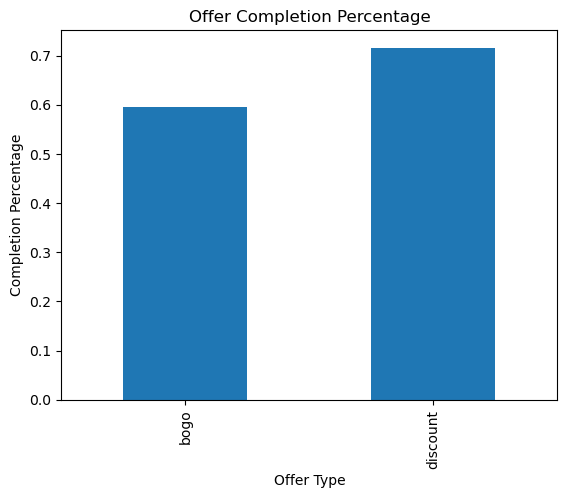

In [ ]:
plot_bar(offer_percent)

Customers seem to prefer the discount offer more than the BOGO (buy one get one free) offer.

## Q2 Does preference for offers differ according to gender? Which gender prefers offers more?

In [ ]:
gender_offer_percent = new_data.groupby(['gender', 'offer_type'])['complet'].sum()/new_data.groupby(['gender', 'offer_type'])['complet'].count()
gender_offer_percent

gender  offer_type
F       bogo          0.701553
        discount      0.792241
M       bogo          0.516893
        discount      0.659348
Name: complet, dtype: float64

Female seem to prefer the discount offer more than male

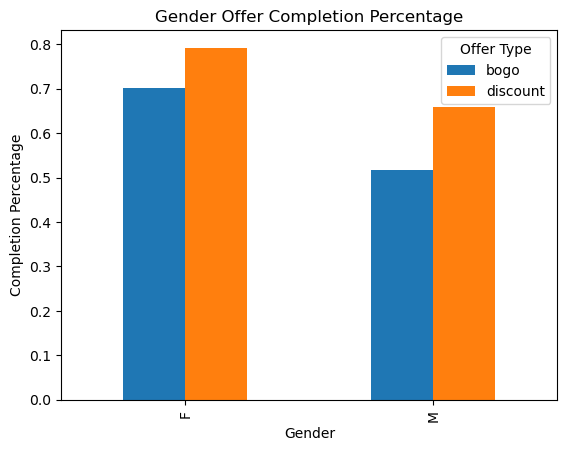

In [ ]:
plot_stack (gender_offer_percent,'Gender')

## Q3

In [ ]:
income_offer_percent= new_data.groupby(['income_category', 'offer_type'])['complet'].sum()/new_data.groupby(['income_category', 'offer_type'])['complet'].count()
income_offer_percent

income_category  offer_type
High             bogo          0.764995
                 discount      0.840208
Low              bogo          0.398200
                 discount      0.571299
Medium           bogo          0.598048
                 discount      0.717187
Name: complet, dtype: float64

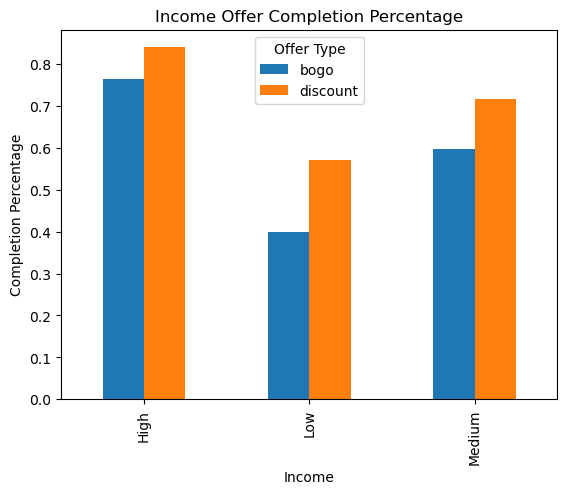

In [ ]:
plot_stack (income_offer_percent,'Income')

High income earners benefit from the offers more than low income earners

# Results

Starbucks customers exhibit a clear preference for discounts over BOGO offers, with approximately 71.59% favoring discounts compared to 59.52% for BOGO deals. Moreover, gender and income levels influence these preferences to varying degrees. 